In [1]:
import os
current_dir = os.getcwd()
if "tscc" in current_dir:
    os.chdir("/tscc/nfs/home/bax001/scratch/CSE_251B")

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm


# Use This if you are using Kaggle Notebook

In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [46]:
# download the dataset to your folder or use it on kaggle notebook directly

train_file = np.load('./data/train.npz')
# train_file = np.load('/kaggle/input/cse-251-b-2025/train.npz')

train_data = train_file['data']
print("train_data's shape", train_data.shape)
test_file = np.load('./data/test_input.npz')
# test_file = np.load('/Users/lilian/Documents/UCSD/CSE 251B/cse-251-b-2025/test_input.npz')

test_data = test_file['data']
print("test_data's shape", test_data.shape)


train_data's shape (10000, 50, 110, 6)
test_data's shape (2100, 50, 50, 6)


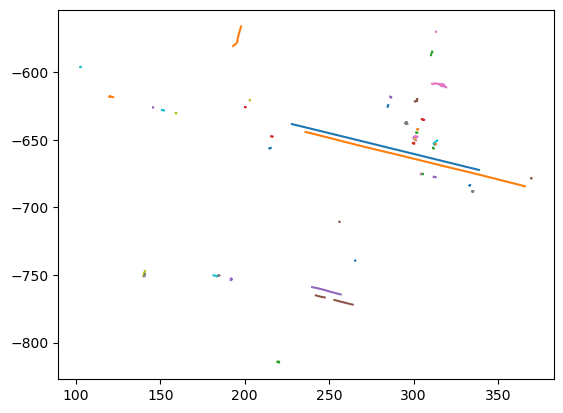

In [ ]:
def plot_scene(scene):
    for i in range(scene.shape[0]):
        xs = scene[i, :, 0]
        ys = scene[i, :, 1]
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.5)
    plt.show()


In [15]:
def constant_velocity_baseline(data):
    velocity = np.mean(data[...,1:,:2] - data[...,:-1,:2], axis=-2)
    start = data[:, 0, -1, :2]
    pred = np.stack([start + (i+1)*velocity for i in range(60)], axis=1)
    return pred


In [16]:
def save_submission(pred, filename):
    reshaped = pred.reshape(-1, 2)
    df = pd.DataFrame(reshaped, columns=['x', 'y'])
    df.index.name = 'index'
    df.to_csv(filename)


In [24]:
class MLP(nn.Module):
    def __init__(self, input_features, output_features):
        super(MLP, self).__init__()
        self.flatten = nn.Flatten()
        self.mlp = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, output_features)
        )

    def forward(self, x):
        x = self.flatten(x)
        return self.mlp(x)

def save_model(model, path="mlp_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")

def load_model(path="mlp_model.pth", input_features=110, output_features=2):
    model = MLP(input_features, output_features)
    model.load_state_dict(torch.load(path))
    model.eval()
    return model


In [43]:
def train_model(model, x_train, y_train, input_features, output_features, batch_size=64, epochs=10, lr=1e-3):
    # Convert numpy arrays to PyTorch tensors
    X_train_tensor = torch.FloatTensor(x_train).reshape((-1, input_features))
    y_train_tensor = torch.tensor(y_train.reshape(-1, output_features), dtype=torch.float32)


    # Create dataset and dataloader
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    # Define loss and optimizer
    criterion = nn.MSELoss()  # Or nn.CrossEntropyLoss() depending on the task
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Training loop
    for epoch in range(epochs):
        running_loss = 0.0
        model.train()
        for batch_X, batch_y in tqdm(train_loader):
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        print(f'Epoch {epoch+1}, Loss: {running_loss / len(train_loader):.4f}')

    return model


In [47]:
# Restrict to 50 agents for training to match test data
X_train = train_data[:, :50, :50, :]           # shape: (10000, 50, 50, 6)
y_train = train_data[:, -60:, 0, :2]           # shape: (10000, 60, 2)

# Flatten for MLP
X_flat = X_train.reshape(10000, -1)            # (10000, 15000)
y_flat = y_train.reshape(10000, -1)            # (10000, 120)

input_features = X_flat.shape[1]               # 15000
output_features = y_flat.shape[1]              # 120

# Re-initialize and train new model
model = MLP(input_features=input_features, output_features=output_features)
trained_model = train_model(model, X_flat, y_flat, input_features, output_features)


100%|██████████| 157/157 [00:09<00:00, 16.95it/s]


Epoch 1, Loss: 1255359.0366


100%|██████████| 157/157 [00:08<00:00, 18.50it/s]


Epoch 2, Loss: 942021.9072


100%|██████████| 157/157 [00:07<00:00, 22.00it/s]


Epoch 3, Loss: 865296.4072


100%|██████████| 157/157 [00:07<00:00, 22.18it/s]


Epoch 4, Loss: 822162.8157


100%|██████████| 157/157 [00:08<00:00, 17.66it/s]


Epoch 5, Loss: 794159.3581


100%|██████████| 157/157 [00:07<00:00, 20.98it/s]


Epoch 6, Loss: 774449.9148


100%|██████████| 157/157 [00:07<00:00, 21.06it/s]


Epoch 7, Loss: 739417.8211


100%|██████████| 157/157 [00:07<00:00, 22.01it/s]


Epoch 8, Loss: 782449.2773


100%|██████████| 157/157 [00:07<00:00, 20.66it/s]


Epoch 9, Loss: 737441.9961


100%|██████████| 157/157 [00:07<00:00, 21.08it/s]

Epoch 10, Loss: 706932.7213


In [ ]:
def predict(model, X_test, input_features):
    """Make predictions with the trained model."""
    model.eval()
    with torch.no_grad():
        if isinstance(X_test, np.ndarray):
            X_test_tensor = torch.FloatTensor(X_test)
        else:
            X_test_tensor = X_test.float()
        X_test_tensor = X_test_tensor.view(-1, input_features)
        predictions = model(X_test_tensor)
    return predictions.numpy()


In [48]:
X_test = test_data.reshape(2100, -1)
preds = predict(trained_model, X_test, input_features=15000)
preds = preds.reshape(-1, 2)

# Save CSV
import pandas as pd
pd.DataFrame(preds, columns=["x", "y"]).to_csv("submission.csv", index=False)


In [49]:
save_model(trained_model, "mlp_model.pth")
load_model("mlp_model.pth", input_features, output_features)

Model saved to mlp_model.pth


MLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (mlp): Sequential(
    (0): Linear(in_features=15000, out_features=1024, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=512, out_features=256, bias=True)
    (7): ReLU()
    (8): Dropout(p=0.1, inplace=False)
    (9): Linear(in_features=256, out_features=100, bias=True)
  )
)

 # Now you can submit to the leaderboard!

In [ ]:
!git add .
!git commit -m "Updated training pipeline for CSE251B MLP"
!git push


[main 3afa6d0] Updated training pipeline for CSE251B MLP
 2 files changed, 26 insertions(+), 3 deletions(-)
Enumerating objects: 7, done.
Counting objects: 100% (7/7), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (4/4), 961 bytes | 961.00 KiB/s, done.
Total 4 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To github.com:LilianHeGao/CSE_251B.git
   4f04b63..3afa6d0  main -> main
